In [1]:
from commonfunctions import *
from utility_functions import *
from skimage.filters import sobel_h, sobel_v, laplace
from skimage.io import imshow, imread
from skimage.filters import threshold_otsu, threshold_niblack, threshold_local, threshold_li, apply_hysteresis_threshold, try_all_threshold
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing, skeletonize, thin
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.feature import canny, blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, match_template
from skimage import  color, data, transform, exposure
from skimage.draw import line,disk, circle_perimeter
from scipy.signal import convolve2d
from scipy.ndimage.morphology import binary_fill_holes

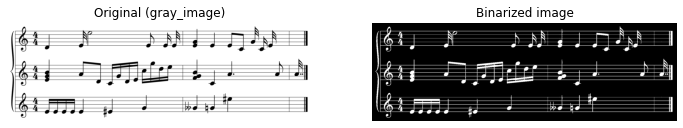

In [2]:
## NOTE you can find a list of musical symbols and their names here https://en.wikipedia.org/wiki/List_of_musical_symbols . 
# This facilitates naming variables and writing comments.
## NOTE We will do the same transformation functions rotate/scale/crop/... on both binary and gray images in parallel
## so that if anyone needed to work on the gray image at any time. it will be available

## Thresholding:
##---------------------------------

# 'test-set-camera-captured/test-cases/22.jpg'
# 'test-set-scanned/test-cases/02.PNG'
gray_image = rgb2gray(imread('test-set-scanned/test-cases/02.PNG'))
binary_image = gray_image
# thresh = threshold_niblack(binary_image, 55, k=0.8)
# thresh = threshold_local(binary_image, block_size=205)  # block_size must be odd


# thresh = threshold_li(binary_image)       # Works well with camera captured images
thresh = threshold_otsu(binary_image)       # Works well with scanned image (High quality images)

binary_image = binary_image < thresh
# binary_image = binary_fill_holes(binary_image)

show_images([gray_image, binary_image], ["Original (gray_image)", "Binarized image"])
# fig, ax = try_all_threshold(gray_image, figsize=(10, 6), verbose=False)

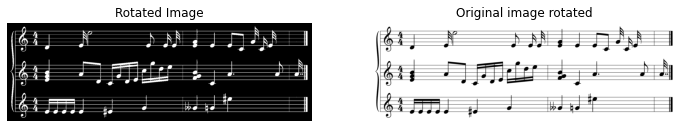

In [3]:
## Initial Orientation Adjustment:
##---------------------------------

#This cell and the next 3 cells were written by Ali & Saad
#And they are equivalent to:
rotated_image, rotation_angle = adjust_orientation(binary_image)
original_image_rotated = transform.rotate(gray_image, rotation_angle, resize=True, clip=False, mode="edge", preserve_range=True)
# If orientation is incorrect (the image was rotated in the reverse direction) then rotate by 180
# This is know by checking the location of the "Brace". If it is on the left side then the orientation is correct.
# if it is on the right side then the orientation is incorrect.
if(not check_if_orientation_is_correct):
    rotated_image = transform.rotate(binary_image, 180, resize=True, clip=False, cval=0, preserve_range=True)
    original_image_rotated = transform.rotate(gray_image, 180, resize=True, clip=False, cval=0, preserve_range=True)
show_images([rotated_image, original_image_rotated], ["Rotated Image" , "Original image rotated"])
binary_image = rotated_image
gray_image = original_image_rotated

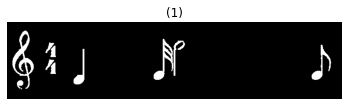

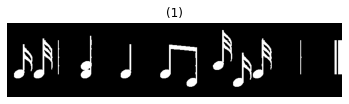

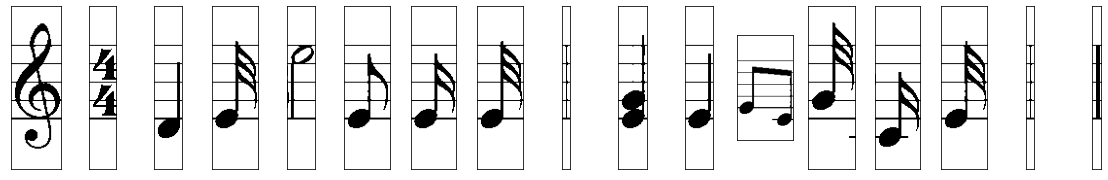

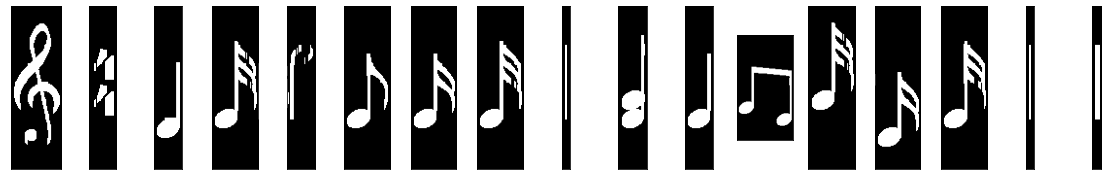

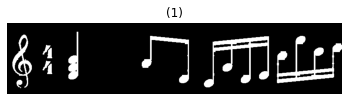

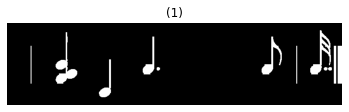

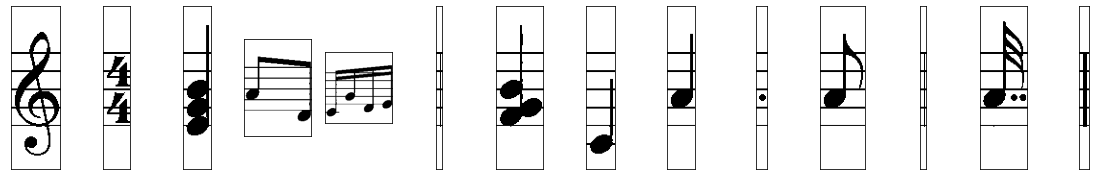

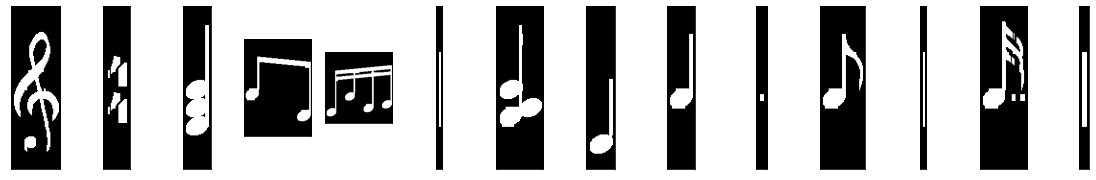

15.210019775873434


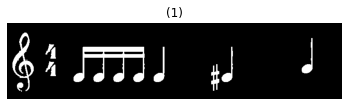

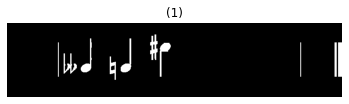

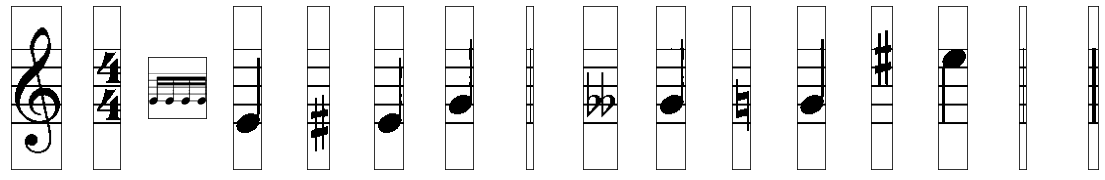

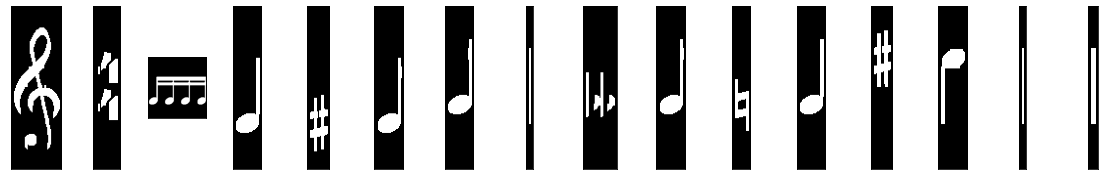

In [4]:
## Row segmentation
row_images, row_images_original, seg_locs = segment_image_into_rows(binary_image, gray_image)

# show_images([remove_staff_lines(row_images[0])])
## Then column segmentation
symbols = []
symbols_no_staff_lines = []
rows_lines = []
second_halves_indexes = []

for i, row_img in enumerate(row_images):
    original_row = row_images_original[i]
    ## Adjust orientation again for each row
    row_img, rotation_angle = adjust_orientation(row_img)
    row_img = np.round(row_img).astype(int)

    ###############################START SPLITTING ROW IN 2 HALVES################################

    row_img, original_row = truncate_left_and_right_empty_spaces(row_img, original_row)
    # row_img, original_row = remove_right_side_bold_barline(row_img, original_row)
    # row_img, original_row = remove_left_side_brace(row_img, original_row)

    vertical_histogram = get_vertical_histogram(row_img)
    max_freq_col = get_most_repeated_pixel_count_in_columns(row_img)
    cut_position = len(vertical_histogram)//2
    while(vertical_histogram[cut_position] > max_freq_col):
        cut_position += 1

    # CUT ROW IN TWO HALVES
    img_row_first_half = row_img[:, :cut_position]
    img_row_second_half = row_img[:, cut_position:]
    original_row_first_half = original_row[:, :cut_position]
    original_row_second_half = original_row[:, cut_position:]

    # ROTATE EACH HALF
    img_row_first_half, rotation_angle = adjust_orientation(img_row_first_half)
    img_row_first_half= np.round(img_row_first_half).astype(int)

    original_row_first_half = transform.rotate(original_row_first_half, rotation_angle, resize=True, clip=False, cval=0)
    original_row_first_half= np.round(original_row_first_half).astype(int)


    img_row_second_half, rotation_angle = adjust_orientation(img_row_second_half)
    img_row_second_half= np.round(img_row_second_half).astype(int)

    original_row_second_half = transform.rotate(original_row_second_half, rotation_angle, resize=True, clip=False, cval=0)
    original_row_second_half= np.round(original_row_second_half).astype(int)

    # show_images([original_row_first_half, original_row_second_half, img_row_first_half, img_row_second_half])

    # EXTRACT (SYMBOLS, SYMBOLS WITHOUT STAFF LINES, AND STAFF LINES POISITIONS) FROM EACH HALF
    first_half_symbols_original, first_half_symbols_no_staff_lines, first_half_lines = segment_symbols(img_row_first_half, original_row_first_half, True)
    second_half_symbols_original, second_half_symbols_no_staff_lines, second_half_lines = segment_symbols(img_row_second_half, original_row_second_half, True)

    symbols_in_row_original = first_half_symbols_original
    symbols_in_row_original.extend(second_half_symbols_original)


    symbols_in_row_no_staff_lines = first_half_symbols_no_staff_lines
    symbols_in_row_no_staff_lines.extend(second_half_symbols_no_staff_lines)

    second_halves_indexes.append(len(first_half_symbols_original))

    symbols.append(symbols_in_row_original)
    symbols_no_staff_lines.append(symbols_in_row_no_staff_lines)

    rows_lines.append([first_half_lines, second_half_lines])

    fig, axs = plt.subplots(1, len(symbols[i]), figsize=(20,3))
    for j, symbol in enumerate(symbols[i]):
        axs[j].imshow(symbol)
        axs[j].set_xticks([]) 
        axs[j].set_yticks([]) 
    plt.show()

    fig, axs = plt.subplots(1, len(symbols_no_staff_lines[i]), figsize=(20,3))
    for j, symbol in enumerate(symbols_no_staff_lines[i]):
        axs[j].imshow(symbol)
        axs[j].set_xticks([]) 
        axs[j].set_yticks([]) 
    plt.show()
    
    #########################END SPLITTING ROW IN 2 HALVES#################################


    # original_row = transform.rotate(original_row, rotation_angle, resize=False, clip=False, cval=0)
    # original_row= np.round(original_row).astype(int)

    # symbols.append(segment_symbols(row_img, original_row))
    # fig, axs = plt.subplots(1, len(symbols[i]), figsize=(20,3))
    # for i, symbol in enumerate(symbols[i]):
    #     axs[i].imshow(symbol)
    #     axs[i].set_xticks([]) 
    #     axs[i].set_yticks([]) 
    # plt.show()


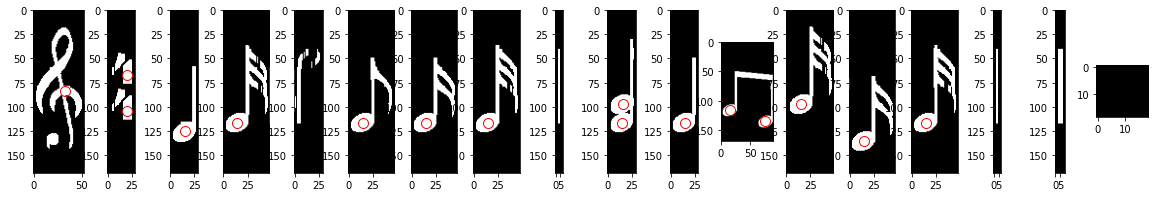

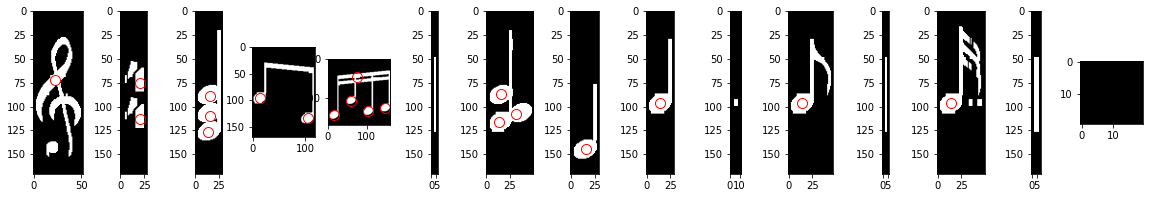

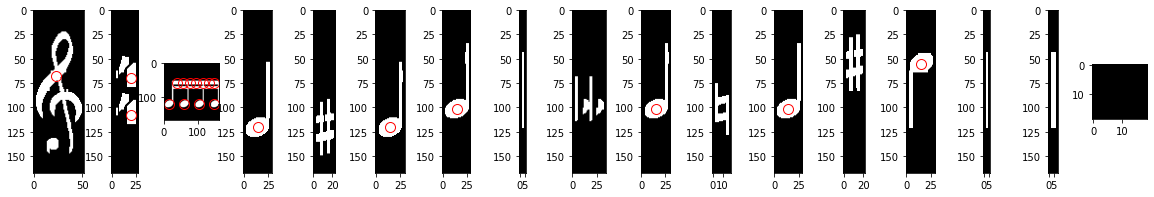

In [5]:
for i, row in enumerate(symbols_no_staff_lines):
    first_half_avg_spacing =  int(get_avg_line_spacing(rows_lines[i][0]))
    second_half_avg_spacing =  int(get_avg_line_spacing(rows_lines[i][1]))

    fig, axs = plt.subplots(1, len(row)+1, figsize=(20,3))
    for j, symbol in enumerate(row):
        diameter = first_half_avg_spacing if j < second_halves_indexes[i] else second_half_avg_spacing
        xArr, yArr = get_circles(symbol, diameter, 1)
        axs[j].imshow(symbol)
        axs[j].plot(xArr, yArr, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

    selem = np.ones((diameter+1, diameter+1), dtype=np.uint8)
    rr, cc = disk((diameter//2, diameter//2), diameter//2)
    selem[rr,cc] = 1
    # print(selem)
    axs[-1].imshow(selem)
    plt.show()

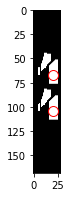

In [6]:
classified_symbols_with_positions = []

for i, row in enumerate(symbols_no_staff_lines):
    First_half_lines = rows_lines[i][0]
    Second_half_lines = rows_lines[i][0]
    first_half_avg_spacing =  int(get_avg_line_spacing(First_half_lines))
    second_half_avg_spacing =  int(get_avg_line_spacing(Second_half_lines))

    for j, symbol in enumerate(row):
        diameter = first_half_avg_spacing if j < second_halves_indexes[i] else second_half_avg_spacing
        lines = First_half_lines if j < second_halves_indexes[i] else Second_half_lines
        
        label = classify_symbol(symbol) # Might need other parameters
        
        classified_symbol_with_position = calc_symbol_position(symbol, label, lines)
        classified_symbols_with_positions.append(classified_symbol_with_position)

        # If Finished computing "classified_symbols_with_positions" for half a row (first or second half)
        if(j == second_halves_indexes[i]-1 or j == len(row)-1):
            lines_locs = lines[:,1]
            pitches = {
                lines_locs[0] - diameter,			#b2
                lines_locs[0] - diameter//2,	    #a2
                lines_locs[0],						#g2
                lines_locs[0] + diameter//2,	    #f2
                lines_locs[1],						#d2
                lines_locs[1] + diameter//2,	    #c2
                lines_locs[2],						#b
                lines_locs[2] + diameter//2,		#a
                lines_locs[3],                      #g
                lines_locs[3] + diameter//2,		#f
                lines_locs[4],						#e
                lines_locs[4] + diameter//2,		#d
                lines_locs[4] + diameter,			#c
            }

            # call francois function(classified_symbols_with_positions, pitches, diameter, "outpath", "imagename")

            classified_symbols_with_positions = []




